# Packages and Functions

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as LA
from scipy.sparse import csr_matrix
import os
import pandas as pd

In [20]:

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#   SBM background network with centered anomaly   
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#



#-----------------------------------------#
#   Create Empirical matrix   
#-----------------------------------------#
"""
Creates empirical matrices with SBM 2-community background structure 
and planted centered anomaly
Inputs:     mat_type = matrix type (A:adjacency, B*:residual of deflation)
            N = matrix size
            K = anomaly size
            p_in = probability of an edge WITHIN the background communities
            p_out = probability of an edge BETWEEN the background communities
            p_anom = probability of an edge WITHIN the anomaly
Outputs:    NxN matrix of type = mat_type encoding the network
            NxN matrix of node degrees (if mat_type is adjacency) 
"""

def get_spiked_SBM(mat_type, N, K, p_in, p_out, p_anom):
    sbm_mat = create_sbm_matrix(N, p_in, p_out)
    anom_mat = create_anom_matrix(K, p_anom)
    mat = sbm_mat
    mat[(N-K)//2:(N+K)//2, (N-K)//2:(N+K)//2] = anom_mat
    mat = make_matrix_symmetric(mat)
    deg = get_matrix_degrees(mat)
    mat = create_matrix_family(mat_type, mat)
    return mat, deg


def create_sbm_matrix(N, p_in, p_out):
    mat = np.random.rand(N, N)
    mat[:N//2, :N//2] = mat[:N//2, :N//2] <= p_in
    mat[:N//2, N//2:] = mat[:N//2, N//2:] <= p_out
    mat[N//2:, :N//2] = mat[N//2:, :N//2] <= p_out
    mat[N//2:, N//2:] = mat[N//2:, N//2:] <= p_in
    return mat


def create_anom_matrix(K, p_anom):
    anom = np.random.rand(K,K)
    anom[:,:] = anom[:,:] <= p_anom
    return anom


def make_matrix_symmetric(mat):
    temp = np.tril(mat, k=-1)
    mat = temp + temp.T + np.diag(np.diag(mat))*1.0  # *1.0 to allow self edges, *0.0 else
    return mat


def get_matrix_degrees(mat):
    deg = np.sum(mat, axis=1)
    return deg


def create_matrix_family(mat_type, adj_mat):
    A = adj_mat
    N = np.shape(A)[0]
    if mat_type == 'A':
        mat = A
    if mat_type == 'B':
        p = np.sum(A)/(N**2)
        mat = A - p*np.ones((N, N))

    # Remove dominant eigen spaces through Spectral Deflation
    if mat_type == 'B1':
        mat = strip_eigenspace('B', A)
    if mat_type == 'B2':
        mat = strip_eigenspace('B', A)
        mat = strip_eigenspace('B', mat)

    # BN - Newman's definition
    if mat_type == 'BN':
        mat = np.zeros((N,N))
        m = np.sum(np.triu(A, k=0))
        d = get_matrix_degrees(A)
        for i in range(N):
            for j in range(N):
                mat[i][j] = A[i][j] - (d[i]*d[j])/(2*m)
    return mat

def strip_eigenspace(mat_type, mat):
    evals, evecs = get_isolated_spectra(mat_type, mat, 1)
    lam = evals[-1]
    vec = evecs[:,-1].reshape(-1,1)
    strip_mat = mat - lam*vec@vec.T
    return strip_mat



#----------------------------------------------------------
# Adjacency Test 2 Setup (Assumes anomaly is not affected by background community)
#----------------------------------------------------------
def get_spiked_SBM_test2(mat_type, N, K, p_in, p_out, p_anom):
    mat = np.random.rand(N, N)
    val = (N-K)//2
    # BR1
    mat[:val, :val] = mat[:val, :val] <= p_in
    mat[:val, val:val+K//2] = mat[:val, val:val+K//2] <= p_in
    mat[:val, val+K//2:val+K] = mat[:val, val+K//2:val+K] <= p_out
    mat[:val, val+K:] = mat[:val, val+K:] <= p_out
    # #BR2
    mat[val:val+K//2, :val] = mat[val:val+K//2, :val] <= p_in
    mat[val:val+K//2, val:val+K//2] = mat[val:val+K//2, val:val+K//2] <= p_in + p_anom
    mat[val:val+K//2, val+K//2:val+K] = mat[val:val+K//2, val+K//2:val+K] <= p_out + p_anom
    mat[val:val+K//2, val+K:] = mat[val:val+K//2, val+K:] <= p_out
    # #BR3
    mat[val+K//2:val+K, :val] = mat[val+K//2:val+K, :val] <= p_out
    mat[val+K//2:val+K, val:val+K//2] = mat[val+K//2:val+K, val:val+K//2] <= p_out + p_anom
    mat[val+K//2:val+K, val+K//2:val+K] = mat[val+K//2:val+K, val+K//2:val+K] <= p_in +p_anom
    mat[val+K//2:val+K, val+K:] = mat[val+K//2:val+K, val+K:] <= p_in
    # #BR4
    mat[val+K:, :val] = mat[val+K:, :val] <= p_out
    mat[val+K:, val:val+K//2] = mat[val+K:, val:val+K//2] <= p_out
    mat[val+K:, val+K//2:val+K] = mat[val+K:, val+K//2:val+K] <= p_in
    mat[val+K:, val+K:] = mat[val+K:, val+K:] <= p_in
    #
    mat = make_matrix_symmetric(mat)
    mat = create_matrix_family(mat_type, mat)
    deg = get_matrix_degrees(mat)
    return mat, deg
#-------------------------------------------------------------


#-----------------------------------------#
#   Get Empirical Spectra   
#-----------------------------------------#
"""
Calculates bulk and isolated empirical eigenvalues and eigenvectors for a given matrix
Inputs:     mat_type = matrix type (A:adjacency, B*:residual of deflation)
            mat = square and symmetric matrix to evaluate
            num_iso_below = number of isolated eigenpairs needed, BELOW the bulk
            num_iso_above = number of isolated eigenpairs needed, ABOVE the bulk
            num_bins = number of bins for the histogram of bulk eigenvalues
Outputs:    distribution of the bulk empirical eigenvalues and bin edges
            empirical boundary of the bulk eigenvalues (lam_b)
            empirical isolated eigenvalues and associated eigenvectors 
"""

def get_empirical_bulk_spectral(mat_type, mat, num_iso_below, num_iso_above, num_bins):
    evals, evecs = get_spectra(mat)
    if (mat_type == 'L') or (mat_type == 'L_hat'):
        counts, bins = np.histogram(evals[num_iso_below:-num_iso_above], num_bins)
    else:
        counts, bins = np.histogram(evals[num_iso_below:-num_iso_above], num_bins)
    empirical_bulk_distribution = counts/sum(counts)/(bins[1]-bins[0])
    return (empirical_bulk_distribution, bins)


def get_empirical_isolated_spectral(mat_type, mat, num_iso):
    evals, evecs = get_isolated_spectra(mat_type, mat, num_iso+1)
    lam_b = evals[0]
    # if mat_type == 'A':
    #     lam_b = evals[0]
    # if mat_type == 'B':
    #     lam_b = evals[1]
    return lam_b, evals[1:], evecs[:,1:]


def get_spectra(mat):
    evals, evecs = np.linalg.eigh(mat) # returns normalized evecs
    idx = np.argsort(evals)  # ascending order indices
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs 


def get_isolated_spectra(mat_type, mat, num_iso):
    sparse_mat = csr_matrix(mat, dtype=np.double)
    if mat_type == 'L' or mat_type == 'L_hat':
        which_evals = 'SA'  # smallest algebraic
    else:
        which_evals = 'LA'  # largest algebraic
    evals, evecs = LA.eigsh(sparse_mat,
                            num_iso,
                            which=which_evals)  # returns ascending order evals
    return evals, evecs


def get_isolated_below(mat, number_isolated_below):
    sparse_mat = csr_matrix(mat, dtype=np.double)
    evals, evecs = LA.eigsh(sparse_mat,
                            number_isolated_below,
                            which='SA')  # returns ascending order evals
    return evals, evecs


#-----------------------------------------#
#   Get Predicted Spectra   
#-----------------------------------------#
"""
Same as Get Empirical Spectra for predicted values using 
random matrix theory and non-negative matrix factorization
New factorization and lifting was implemented to account for
background SBM
"""

def get_predicted_bulk_spectral(mat_type, N, P1, bin_centers):
    mean = 0
    variance = np.sqrt(4*N*P1*(1-P1))
    if mat_type == 'L':
        mean = N*P1
    if mat_type == 'L_hat':
        mean = 1
    if mat_type == 'A_hat' or mat_type == 'B_hat' or mat_type == 'L_hat':
        variance = np.sqrt(4*N*P1*(1-P1)/(N*P1)**2)
    spct = wigner_distribution(bin_centers, mean, variance)
    return mean, variance, spct


def wigner_distribution(z, mean, variance):
    P = np.zeros(len(z))
    support_ids = variance**2 > (z-mean)**2
    P_fun = lambda z : 2/(np.pi*variance**2)*np.sqrt(variance**2-(z-mean)**2)
    P[support_ids] = P_fun(z[support_ids])
    return P


def get_predicted_isolated_spectral(mat_type, N, K, prob_in, prob_out, prob_anom):
    rho = (prob_in + prob_out)/2
    pi_mat, y = get_spiked_SBM_pi_matrix(mat_type, N, K, prob_in, prob_out, prob_anom)
    gamma, w = get_pi_spectral(pi_mat)
    theta, u, norms = get_thetas(gamma, w, y)
    pred_lambda_b, pred_lambdas = get_predicted_lambdas(mat_type, rho, N, theta)
    (pred_lambdas, theta, gamma, u, w) = order_lambdas(pred_lambdas, theta, gamma, u, w)
    return pred_lambda_b, pred_lambdas, u, theta


def get_spiked_SBM_pi_matrix(mat_type, N, K, pin, pout, panom):
    rho = (pin+pout)/2
    delta = (pin-pout)
    Y = get_y_SBM(N, K)
    if K == 0:
        if mat_type == "A":
            pi_mat = np.array([[pin, pout], [pout, pin]])
            
        if mat_type == "B1" or mat_type == 'B':
            pi_mat = np.array([[delta/2, delta/2, -delta/2, -delta/2],
                            [delta/2, panom-rho, panom-rho, -delta/2],
                            [-delta/2, panom-rho, panom-rho, delta/2],
                            [-delta/2, -delta/2, delta/2, delta/2]])
            
        if mat_type == 'B2':
            pi_mat = np.array([[0,0,0,0],
                            [0,panom-pin, panom-pout,0],
                            [0,panom-pout, panom-pin,0],
                            [0,0,0,0]])
    if K > 0:
        if mat_type == "A":
            pi_mat = np.array([[pin, pin, pout, pout],
                            [pin, panom, panom, pout],
                            [pout, panom, panom, pin],
                            [pout, pout, pin, pin]])
            
        if mat_type == "B1" or mat_type == 'B':
            pi_mat = np.array([[delta/2, delta/2, -delta/2, -delta/2],
                            [delta/2, panom-rho, panom-rho, -delta/2],
                            [-delta/2, panom-rho, panom-rho, delta/2],
                            [-delta/2, -delta/2, delta/2, delta/2]])
            
        if mat_type == 'B2':
            pi_mat = np.array([[0,0,0,0],
                            [0,panom-pin, panom-pout,0],
                            [0,panom-pout, panom-pin,0],
                            [0,0,0,0]])

 
        
        #---------------------------------------------------------
        # Adjacency 2 (previous test)
        #---------------------------------------------------------
        # # B1 and BN
        # pi_mat = np.array([[delta/2, delta/2, -delta/2, -delta/2],
        #                    [delta/2, delta/2+panom, -delta/2+panom, -delta/2],
        #                    [-delta/2, -delta/2+panom, delta/2+panom, delta/2],
        #                    [-delta/2, -delta/2, delta/2, delta/2]])
        # # B2
        # pi_mat = pi_mat + np.array([[-delta/2, -delta/2, delta/2, delta/2],
        #                             [-delta/2, -delta/2, delta/2, delta/2],
        #                             [delta/2, delta/2, -delta/2, -delta/2],
        #                             [delta/2, delta/2, -delta/2, -delta/2]])
        # #---------------------------------------------------------
  
    return pi_mat, Y


def get_y_SBM(N, K):  
    if K > 0:
        y1 = np.zeros(N)
        y1[:(N-K)//2] = 1
        y4 = np.zeros(N)
        y4[N-(N-K)//2:] = 1
        y2 = np.zeros(N)
        y2[(N-K)//2:(N-K)//2+K//2]=1
        y3=np.zeros(N)
        y3[(N-K)//2+K//2:(N-K)//2+K]=1
        Y = np.array([y1,y2,y3,y4])
    if K == 0:
        y1 = np.zeros(N)
        y2 = np.zeros(N)
        y1[:N//2] = 1
        y2[N//2:] = 1
        Y = np.array([y1,y2])
    return Y.T


def get_pi_spectral(pi_mat):
    gamma, w = get_spectra(pi_mat) 
    return gamma, w


def get_thetas(gamma, w, y):
    yw = y @ w
    norms = np.linalg.norm(yw, axis=0)
    u = yw / norms
    theta = gamma * norms**2
    return theta, u, norms


def get_lambda_b(mat_type, N, prob):
    val = 0
    if mat_type == "A" or mat_type == "B" or mat_type == "B1" or mat_type == "B2":
        val = np.sqrt(4*N*prob*(1-prob))
    if mat_type == "A_hat" or mat_type == "B_hat" or mat_type == "L_hat":
        val = np.sqrt(4*N*prob*(1-prob)/(N*prob)**2)
    if mat_type == "L_hat":
        val = 1 - np.sqrt(4*N*prob*(1-prob)/(N*prob)**2)
    if mat_type == "L":
        val = N*prob - np.sqrt(4*N*prob*(1-prob))
    return val


def get_predicted_lambdas(mat_type, p, N, theta):
    num_blocks = np.shape(theta)[0]
    lam = np.zeros(num_blocks)
    lam_b = get_lambda_b(mat_type, N, p)
    if mat_type == "L" or mat_type == "L_hat":
        for i in range(num_blocks):
            if 2*theta[1] > lam_b:
                lam[1] = theta[1] * (1 + (lam_b / 2 / theta[1])**2)
            else:
                lam[1] = lam_b
        lam[0] = 0
    types = ['A', 'A_hat','B', 'B_hat', 'B1', 'B2']
    if any(types):
        for i in range(num_blocks):
            if 2*theta[i] > lam_b:
                lam[i] = theta[i] * (1 + (lam_b / 2 / theta[i])**2)
            else:
                lam[i] = lam_b
    return lam_b, lam


def order_lambdas(lamdas, thetas, gammas, u_vecs, w_vecs):
    idx = lamdas.argsort()[::1]  # ascending order indices
    lamdas = lamdas[idx]
    thetas = thetas[idx]
    gammas = gammas[idx]
    u_vecs = u_vecs[:, idx]
    w_vecs = w_vecs[:, idx]
    return lamdas, thetas, gammas, u_vecs, w_vecs



#-----------------------------------------#
#  New Factorization and Lifting
#-----------------------------------------#


def get_factorization_spectra(Pi, Y):
    Pmat = Y.T@Y
    Qmat = np.sqrt(Pmat)@Pi@np.sqrt(Pmat)
    Qevals, Qevecs = get_spectra(Qmat)
    return Qevals, Qevecs


def get_lifted_spectra(Qevals, Qevecs, Y):
    Pmat = Y.T@Y
    evals = Qevals
    evecs = Y@np.linalg.inv(np.sqrt(Pmat))@Qevecs
    return evals, evecs

def get_predicted_isolated_spectral_new(mat_type, pi_mat, y_mat, rho, N):
    factored_evals, factored_evecs = get_factorization_spectra(pi_mat, y_mat)
    lifted_evals, lifted_evecs = get_lifted_spectra(factored_evals, factored_evecs, y_mat)
    pred_lambda_b, pred_lambdas = get_predicted_lambdas(mat_type, rho, N, lifted_evals)
    pred_evecs = lifted_evecs
    return pred_lambda_b, pred_lambdas, pred_evecs, lifted_evals



#-----------------------------------------#
#         Inner Products                  #
#-----------------------------------------#
"""
Measures accuracy of anomaly detection theory through innerproduct of 
empirical eigenvector and predicted eigenvector and tests against RMT theory
"""
def get_empirical_inner_product(emp_u, pred_u):
    num_blocks = np.shape(emp_u)[1]
    ip = np.empty(num_blocks)
    for i in range(num_blocks):
        ip[i] = np.dot(emp_u[:, i], pred_u[:, i])**2
    return ip


def get_pred_ip(mat_type, lam_b, theta):
    num_blocks = np.shape(theta)[0]
    ip = np.zeros(num_blocks)
    for i in range(num_blocks):
        if 2*theta[i] > lam_b:
            ip[i] = 1 - (lam_b / 2 / theta[i])**2
        else:
            ip[i] = 0
    return ip



#-----------------------------------------#
#  Expected matrix for testing
#-----------------------------------------#
"""
Returns the expected values for the matrix for testing and debugging
"""
def get_expected_mat(mat_type, N, K, pin, pout, panom):
    if mat_type == "A":
        mat = np.full((N,N), pin)
        mat[:N//2, N//2:] = pout
        mat[N//2:, :N//2] = pout
        mat[(N-K)//2:(N+K)//2, (N-K)//2:(N+K)//2] = panom
        # mat = np.full((N,N), p1)
        # mat[:k, :k] = p2
    if mat_type == "B":
        mat = np.zeros((N,N))
        mat[:k, :k] = p2-p1
    if mat_type == "A_hat":
        mat = np.full((N,N), 1/N)
        mat[:k, :k] = p2/N/p1
    if mat_type == "B_hat":
        mat = np.zeros((N,N))
        mat[:k, :k] = (p2-p1)/p1/N
    if mat_type == "L":
        mat = np.full((N,N), -p1)
        mat[:k, :k] = p1*(N/k - 1)
        mat[-(N-k):, -(N-k):] = 0
    if mat_type == "L_hat":
        mat = np.full((N,N), -1/N)
        mat[:k, :k] = 1/k - p2/N/p1
        mat[-(N-k):, -(N-k):] = 1/(N-k) - 1/N
    return mat




#-----------------------------------------#
#  Other
#-----------------------------------------#
def fix_sign(vec):
       if vec[0] < 0:
              vec = -vec
       if vec[len(vec)//2-5] < 0:
              vec = -vec
       return vec



# Main Code

In [22]:
#------------------------
# Parameters
#------------------------
mat_type = 'A'
num_isolated_above = 4
num_isolated_below = 0

N = 5000
prob_in = .1
prob_out = .02
prob_anom = 1
rho = (prob_in + prob_out)/2

# Various anomaly sizes to test
# sizes = [16, 18, 20]
sizes = [12]
# sizes = np.linspace(10, 50, 21, dtype=int)

# Filepath to save data
filepath = f'../data/' + str(N)

#------------------------
# Iterate through anomaly sizes
#------------------------
print(sizes)
for i, K in enumerate(sizes):
    print(K)
    filename = f'/{K}_{prob_in}_{prob_out}_{mat_type}'

    #------------------------
    # Create Matrices
    #------------------------
    spiked_mat, adj_degrees = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
    pi_mat, y_mat = get_spiked_SBM_pi_matrix(mat_type, N, K, prob_in, prob_out, prob_anom)

    #------------------------
    # Isolated Spectral
    #------------------------
    emp_lambda_b, emp_lambdas, emp_evecs = get_empirical_isolated_spectral(mat_type, spiked_mat, num_isolated_above)
    pred_lambda_b, pred_lambdas, pred_evecs, thetas = get_predicted_isolated_spectral_new(mat_type, pi_mat, y_mat, rho, N)
    np.save(filepath + filename + f'_pred_boundaries.npy', pred_lambda_b)
    np.save(filepath + filename + f'_pred_lambdas.npy', pred_lambdas)
    np.save(filepath + filename + f'_pred_evecs.npy', pred_evecs)
    np.save(filepath + filename + f'_emp_boundaries.npy', emp_lambda_b)
    np.save(filepath + filename + f'_emp_lambdas.npy', emp_lambdas)
    np.save(filepath + filename + f'_emp_evecs.npy', emp_evecs)


    #------------------------
    # Bulk Spectral 
    # Time-intensive
    # (Comment out if not needed)
    # ------------------------
    emp_blk_spct, emp_blk_bins = get_empirical_bulk_spectral(mat_type, spiked_mat, num_isolated_below, num_isolated_above, 50)
    mean, variance, pred_blk_spct = get_predicted_bulk_spectral(mat_type, N, rho, emp_blk_bins)
    np.save(filepath + filename + f'_pred_blk_spct.npy', pred_blk_spct)
    np.save(filepath + filename + f'_emp_blk_spct.npy', emp_blk_spct)
    np.save(filepath + filename + f'_emp_blk_bins.npy', emp_blk_bins)
    
    #------------------------
    # Inner Products
    #------------------------
    pred_ip = get_pred_ip(mat_type, pred_lambda_b, thetas)
    emp_ip = get_empirical_inner_product(emp_evecs, pred_evecs)
    np.save(filepath + filename + f'_emp_ips.npy', emp_ip)
    np.save(filepath + filename + f'_pred_ips.npy', pred_ip)

    #------------------------
    # Isolated Spectra Below Bulk
    #------------------------
    if num_isolated_below > 0:
        lambdas_below, evecs_below = get_isolated_below(spiked_mat, num_isolated_below)  
        np.save(filepath + filename + f'_emp_lambdas_below.npy', lambdas_below)
        np.save(filepath + filename + f'_emp_evecs_below.npy', evecs_below)


    #------------------------
    # Node Degrees
    #------------------------
    if mat_type == 'A':
        np.save(filepath + filename + f'_degrees.npy', adj_degrees)

print('DONE')



[12]
12
DONE


# Visualize Network

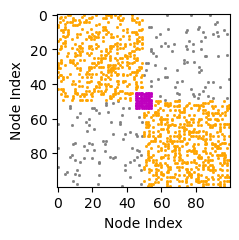

In [23]:
mat_type = 'A'
N = 100
K = 10


#------------------------
# Show Adjacency Matrix
# ------------------------
fig,ax = plt.subplots(1, figsize=(2.5,2.5))
fig.tight_layout()
ax.set_xlabel('Node Index')
ax.set_ylabel('Node Index')

## (sparse background)
prob_in = 0
prob_out = .04
prob_anom = 0
mat, degmat = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
ax.spy(csr_matrix(mat), markersize=1, color='grey')

## (sbm background)
prob_in = .2
prob_out = 0
prob_anom = 0
mat, degmat = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
ax.spy(csr_matrix(mat), markersize=1, color='orange')

## (anomaly)
prob_in = 0
prob_out = 0
prob_anom = .8
mat, degmat = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
ax.spy(csr_matrix(mat), markersize=1, color='m')

ax.xaxis.set_ticks_position('bottom')


# ------------------------
# Get node/egde .csv data
# ------------------------
prob_in = .2
prob_out = .04
prob_anom = .8
mat, degmat = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
emp_lambda_b, emp_lambdas, emp_evecs = get_empirical_isolated_spectral(mat_type, mat, 1)
nodes = pd.DataFrame({'Weight': fix_sign(emp_evecs).flatten()})
rows, cols = mat.nonzero()
edges = pd.DataFrame({'Source': rows, 'Target':cols})
weights = [0]*len(edges)
for i in range(len(edges)):
    s = edges['Source'][i]
    t = edges['Target'][i]
    weights[i] = nodes['Weight'][s] + nodes['Weight'][t] 
edges['Weight'] = weights


# ------------------------
# Save
# ------------------------
fig.savefig('../figures/raw/fig4_mat.pdf', bbox_inches='tight')
nodes.to_csv("../data/gephi/nodes_sbm.csv", index=True, index_label='Id')
edges.to_csv("../data/gephi/edges_sbm.csv", index=False)


# Testing

<A> evals: 
 [ 46.44391002 199.98019608 300.55608998]
Q evals: 
 [ 46.44391002 199.98019608 300.55608998]
||U|| (columns): 
 [1. 1. 1. 1.]
A evals: 
 [ 52.10534082 201.42454711 301.24518983]
Lambdas: 
 [ 52.51575023 201.39033571 301.49435078]


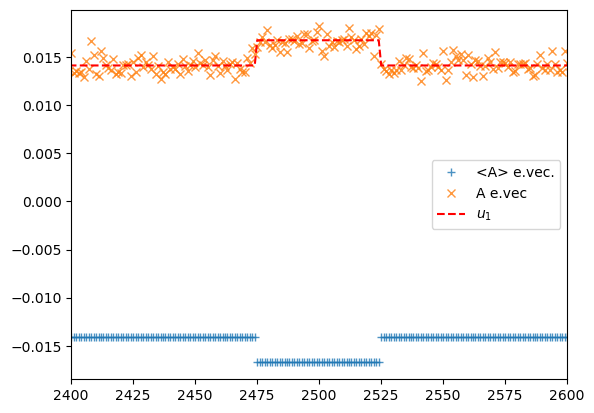

In [24]:
# Factorization and Lifting

mat_type = 'A'
N = 5000
K = 50
prob_in = .1
prob_out = .02
prob_anom = 1
rho = (prob_in+prob_out)/2

ExpA = get_expected_mat(mat_type, N, K, prob_in, prob_out, prob_anom)
Pi, Y = get_spiked_SBM_pi_matrix('A', N, K, prob_in, prob_out, prob_anom)
A, deg = get_spiked_SBM(mat_type, N, K, prob_in, prob_out, prob_anom)
ExpA_evals, ExpA_evecs = get_isolated_spectra(mat_type, ExpA, 4)
A_evals, A_evecs = get_isolated_spectra(mat_type, A, 4)

N_mat = Y.T@Y
sN = np.sqrt(N_mat)
sNi = np.linalg.inv(sN)
Q = sN@Pi@sN
Qevals, Qevecs = get_pi_spectral(Q)
U = Y@sNi@Qevecs
norms = np.linalg.norm(U, axis=0)
lam_b, lams = get_predicted_lambdas(mat_type, rho, N, Qevals)

print('<A> evals: \n', ExpA_evals[1:])
print('Q evals: \n', Qevals[1:])
print('||U|| (columns): \n', norms)
print('A evals: \n', A_evals[1:])
print('Lambdas: \n', lams[1:])

plt.plot(-ExpA_evecs[:,-1], '+', label='<A> e.vec.', alpha=.8)
plt.plot(A_evecs[:,-1], 'x', label='A e.vec', alpha=.8)
plt.plot(-U[:,-1], '--', label='$u_1$', c='r')
plt.xlim(2400,2600)
plt.legend()